## Description:

    Ordinate enzyme data
    Regress axes against OTU abundance in DESeq


# Setting variables

In [1]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "phyloseq", "dplyr", "tidyr", "lmerTest",
           "reshape2", "vegan", "RColorBrewer", "lsmeans")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.1’
[1] "lmerTest"
[1] ‘2.0.33’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "RColorBrewer"
[1] ‘1.1.2’
[1] "lsmeans"
[1] ‘2.25.5’


In [4]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


In [5]:
%%R
#set color scales
library(RColorBrewer)
FertColors = brewer.pal(3, 'YlOrRd')

GenotypeColors = colorRampPalette(brewer.pal(11,'RdYlBu'))(12)
GenotypeColors %>% print

GenotypeColors_sub6 = GenotypeColors[c(2,4,6,8,10,12)]
GenotypeColors_sub6 

 [1] "#A50026" "#D22B26" "#EE613D" "#FA9C58" "#FDCD7E" "#FEF0A9" "#F0F9D8"
 [8] "#CCE9F2" "#9CCDE2" "#6BA2CB" "#436FB1" "#313695"
[1] "#D22B26" "#FA9C58" "#FEF0A9" "#CCE9F2" "#6BA2CB" "#313695"


In [6]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [7]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [8]:
%%R

#remove BARE soil controls and untreated seeds
physeq.plant = subset_samples(physeq.Full, Genotype != "Bare" & SeedTreatment == "Treated")


# Remove ordination outliers, see Ordination notebook
#physeq.plant = subset_samples(physeq.plant, !X.sampleID %in% c("ERA-T2_1-4c_85", "ERA-T2_4-4d_85"))


# Set rep as a factor
sample_data(physeq.plant)$Rep = factor(sample_data(physeq.plant)$Rep)   
sample_data(physeq.plant)$ERA = factor(sample_data(physeq.plant)$ERA)  
sample_data(physeq.plant)$Fert = factor(sample_data(physeq.plant)$Fert)  

sample_data(physeq.plant)$R_Year.c = sample_data(physeq.plant)$R_Year - 1935
physeq.plant


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 195 samples ]
sample_data() Sample Data:       [ 195 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


# Ordinate all time points of core data

In [200]:
%%R

sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep)   
sample_data(physeq.Full)$ERA = factor(sample_data(physeq.Full)$ERA)  
sample_data(physeq.Full)$Fert = factor(sample_data(physeq.Full)$Fert)  

sample_data(physeq.Full)$R_Year.c = sample_data(physeq.Full)$R_Year - 1935

physeq.core = subset_samples(physeq.Full, Plant %in% c("Bare", "330", "34M95", "354", "3475", "3517", "P1151HR") & 
                             Fert == "85" & !is.na(BG_activity.g)) 

# # PCA of enzymes
sd = as(sample_data(physeq.core), "data.frame")
rownames(sd) = sd$X.sample

#tmp = filter(sd, X.sampleID != "ERA-T1_4-5b_85")

sd %>% select(BG_activity.g, BX_activity.g,CB_activity.g, LAP_activity.g, NAG_activity.g) %>%
    as.matrix %>%
Hmisc::rcorr()

               BG_activity.g BX_activity.g CB_activity.g LAP_activity.g
BG_activity.g           1.00          0.58          0.61           0.21
BX_activity.g           0.58          1.00          0.86           0.48
CB_activity.g           0.61          0.86          1.00           0.43
LAP_activity.g          0.21          0.48          0.43           1.00
NAG_activity.g          0.64          0.70          0.70           0.46
               NAG_activity.g
BG_activity.g            0.64
BX_activity.g            0.70
CB_activity.g            0.70
LAP_activity.g           0.46
NAG_activity.g           1.00

n= 84 


P
               BG_activity.g BX_activity.g CB_activity.g LAP_activity.g
BG_activity.g                0.0000        0.0000        0.0496        
BX_activity.g  0.0000                      0.0000        0.0000        
CB_activity.g  0.0000        0.0000                      0.0000        
LAP_activity.g 0.0496        0.0000        0.0000                      
NAG_activity.g 0

Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.6660 0.8582 0.54482 0.43734
Proportion of Variance 0.6938 0.1841 0.07421 0.04782
Cumulative Proportion  0.6938 0.8780 0.95218 1.00000
                      PC1         PC2         PC3        PC4
BG_activity.g  -0.5360696  0.34796603 -0.03237235  0.7684406
CB_activity.g  -0.5343185  0.18268815  0.70705211 -0.4256831
LAP_activity.g -0.3695068 -0.91413699  0.05230812  0.1583734
NAG_activity.g -0.5390713  0.09948997 -0.70448081 -0.4507890


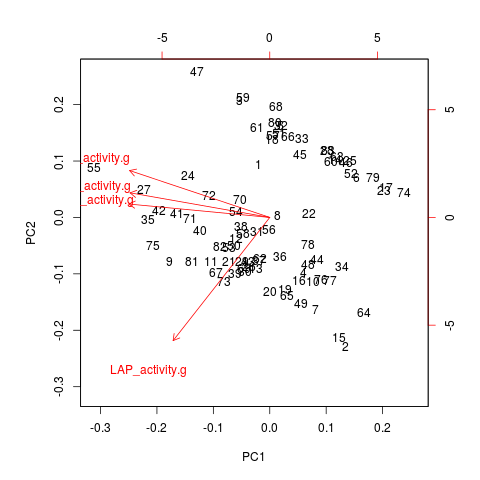

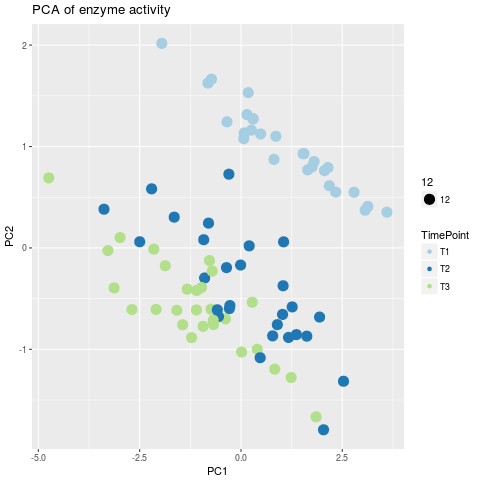

In [201]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.core), "data.frame")
rownames(sd) = sd$X.sample

tmp = filter(sd, X.sampleID != "ERA-T1_4-5b_85")
fit = prcomp(~BG_activity.g +  CB_activity.g + LAP_activity.g + NAG_activity.g, data = tmp, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(tmp, S)
rownames(TM_Fit) = TM_Fit$X.sample
#sample_data(physeq.plant) = TM_Fit



p = ggplot(TM_Fit, aes(PC1, PC2, color = TimePoint, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity")
p

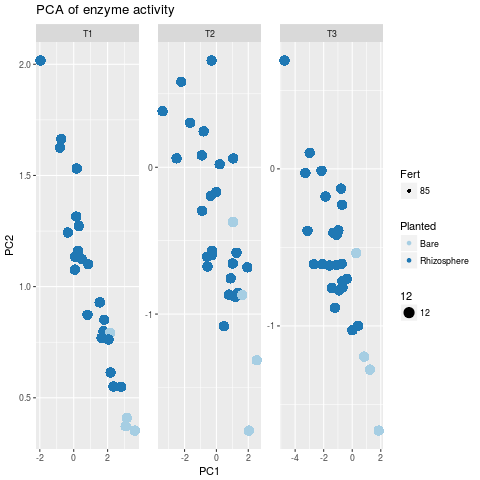

In [202]:
%%R
TM_Fit = TM_Fit %>% mutate(Planted = ifelse(Genotype == "Bare", "Bare", "Rhizosphere"))
p = ggplot(TM_Fit, aes(PC1, PC2, color = Planted, shape = Fert, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity")
p = p + facet_wrap(~TimePoint, scales = "free")
p

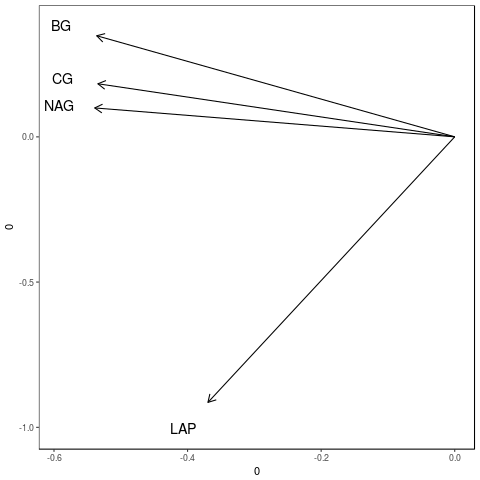

In [180]:
%%R
# Now plot loading arrows
arrowmat <- vegan::scores(fit, display = "species")

rownames(arrowmat) = c("BG", "CG", "LAP", "NAG")
#rownames(arrowmat) = c("BX", "CB", "LAP", "NAG")

# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = PC1, 
    yend = PC2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.1 * PC1, 
    y = 1.1 * PC2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

pA.c = ggplot() +
    geom_segment(arrow_map, 
    #size = .5, 
    data = arrowdf, 
    color = "black", 
    arrow = arrowhead
    ) + 
geom_text(label_map,   
    data = arrowdf, 
    show_guide = FALSE, size = 5) + 
    theme_pub()  
    #theme(axis.text = element_blank())
pA.c

### Join enzyme ordination scores with phyloseq object

In [181]:
%%R
PCscore = TM_Fit %>%
    select(X.sampleID, PC1, PC2, PC3)
colnames(PCscore)[2:4] = c("EnzPC1", "EnzPC2", "EnzPC3")

In [182]:
%%R
sd = left_join(sd, PCscore, by = "X.sampleID")
rownames(sd) = sd$X.sampleID
physeq.plantenz = physeq.plant
sample_data(physeq.plantenz) = sd

# Core sample enzyme analysis

* Two tests: bare vs rhizosphere over time and rhizosphere genotypes over time

In [183]:
%%R
### Quick seed treatment check
sd$Plant %>% levels


[1] "330"     "3475"    "34M95"   "3517"    "354"     "Bare"    "P1151HR"


In [184]:
%%R
m1 = lmer(PC1~Planted*TimePoint + (1|Rep) + (1|Rep:Genotype),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~Planted*TimePoint + (1|Rep) + (1|Rep:Genotype),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                   Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
Planted           21.5494 21.5494     1 22.760 28.0637 2.311e-05 ***
TimePoint         29.6175 14.8087     2 51.066 19.2854 5.767e-07 ***
Planted:TimePoint  0.5392  0.2696     2 51.066  0.3511    0.7056    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                   Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
Planted            3.6448  3.6448     1 22.637  25.132 4.715e-05 ***
TimePoint         21.7431 10.8715     2 51.118  74.963 6.305e-16 ***
Planted:TimePoint  0.0546  0.0273     2 51.118   0.188    0.8289    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [185]:
%%R
#Generate lsmeans for Axes1 

Axis1.lsm.df = lsmeans(m1, pairwise~Planted) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Planted,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~Planted) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Planted,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

Core.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "Planted") #%>%
   # mutate(TimePoint = "Core")
Core.lsm.df

      Planted Axis1.lsmean  Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1        Bare    1.9482180 0.4803322      0.9163981      2.9800378   -0.5917615
2 Rhizosphere   -0.3242194 0.3156337     -1.2880097      0.6395708    0.1152045
   Axis2.SE Axis2.lower.CL Axis2.upper.CL
1 0.1570081     -0.9282952     -0.2552277
2 0.1024924     -0.1968613      0.4272703


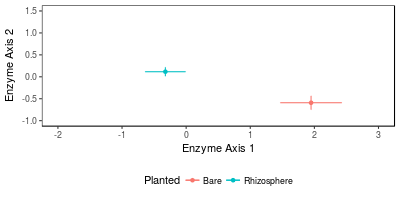

In [186]:
%%R -w 400 -h 200
pP= ggplot(Core.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = Planted)) +
    geom_point()+
    theme_pub()+
    xlim(c(-2,3))+
    ylim(c(-1,1.5))+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Planted),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Planted),
                height = .002) +
    theme(legend.position = "bottom")+
    xlab("Enzyme Axis 1")+
    ylab("Enzyme Axis 2")#
pP

In [187]:
%%R
sub = TM_Fit %>% filter(Planted == "Rhizosphere") %>% 
    mutate(R_Year.f = factor(R_Year))
m1 = lmer(PC1~R_Year.f*TimePoint + (1|Rep) + (1|Rep:Genotype),  data = sub, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.f*TimePoint + (1|Rep) + (1|Rep:Genotype),  data = sub, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                   Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
R_Year.f           18.930  3.7860     5 14.888   4.114   0.01509 *  
TimePoint          59.409 29.7044     2 35.441  32.281 1.039e-08 ***
R_Year.f:TimePoint  6.604  0.6604    10 35.380   0.718   0.70235    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                   Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
R_Year.f            0.546  0.1092     5 14.890   0.596    0.7040    
TimePoint          33.286 16.6432     2 35.455  90.791 1.124e-14 ***
R_Year.f:TimePoint  0.608  0.0608    10 35.393   0.332    0.9664    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [188]:
%%R
#Generate lsmeans for Axes1 

Axis1.lsm.df = lsmeans(m1, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

Core.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "R_Year.f") #%>%
   # mutate(TimePoint = "Core")
Core.lsm.df

  R_Year.f Axis1.lsmean  Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1     1939  -0.43119359 0.4390766     -1.4622143      0.5998272   0.09396462
2     1953  -0.48046475 0.4390766     -1.5114855      0.5505560   0.11222569
3     1971  -1.24096240 0.4390766     -2.2719832     -0.2099417   0.28206022
4     1984   0.58211188 0.4390766     -0.4489089      1.6131326  -0.04030264
5     2001   0.05585149 0.4495925     -0.9826660      1.0943690   0.11200478
6     2011  -0.39892526 0.4390766     -1.4299460      0.6320955   0.11486770
   Axis2.SE Axis2.lower.CL Axis2.upper.CL
1 0.1525229    -0.23346641      0.4213956
2 0.1525229    -0.21520534      0.4396567
3 0.1525229    -0.04537081      0.6094912
4 0.1525229    -0.36773367      0.2871284
5 0.1584301    -0.22445701      0.4484666
6 0.1525229    -0.21256333      0.4422987


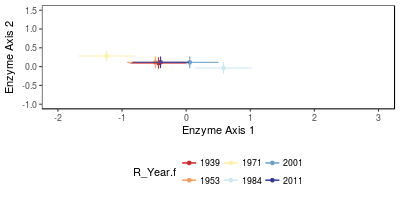

In [190]:
%%R -w 400 -h 200
pF = ggplot(Core.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = R_Year.f)) +
    geom_point()+
    scale_color_manual(values = GenotypeColors_sub6) +
    theme_pub()+
       xlim(c(-2,3))+
    ylim(c(-1,1.5))+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = R_Year.f),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = R_Year.f),
                height = .002) +
    theme(legend.position = "bottom")+
    xlab("Enzyme Axis 1")+
    ylab("Enzyme Axis 2")#
pF %>% print
#pF = pF + theme(legend.position = "none")

In [189]:
%%R
#Generate lsmeans for Axes1 

Axis1.lsm.df = lsmeans(m1, pairwise~TimePoint) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(TimePoint,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~TimePoint) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(TimePoint,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

Core.time.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "TimePoint") 
Core.time.lsm.df

  TimePoint Axis1.lsmean  Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1        T1    0.7386316 0.3826733     -0.2766035      1.7538668    1.0900132
2        T2   -0.1887218 0.3796085     -1.2067991      0.8293554   -0.2923803
3        T3   -1.5067011 0.3796085     -2.5247783     -0.4886239   -0.4602227
   Axis2.SE Axis2.lower.CL Axis2.upper.CL
1 0.1188954      0.8142328     1.36579362
2 0.1169483     -0.5667243    -0.01803644
3 0.1169483     -0.7345666    -0.18587877


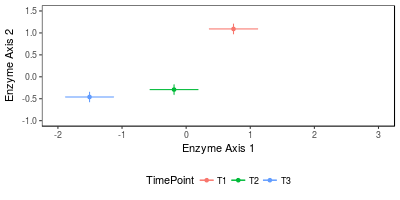

In [37]:
%%R -w 400 -h 200
pT = ggplot(Core.time.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = TimePoint)) +
    geom_point()+
    theme_pub()+
       xlim(c(-2,3))+
    ylim(c(-1,1.5))+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = TimePoint),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = TimePoint),
                height = .002) +
    theme(legend.position = "bottom")+
    xlab("Enzyme Axis 1")+
    ylab("Enzyme Axis 2")

pT

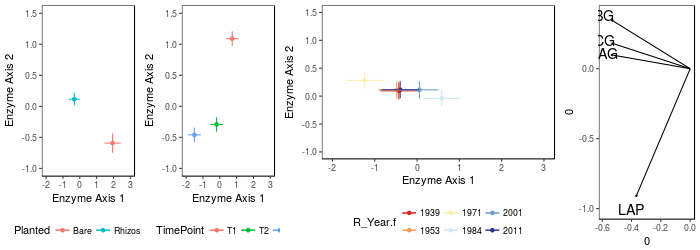

In [193]:
%%R -w 700 -h 250
GCore = grid.arrange(pP, pT, pF, pA.c, ncol = 4, widths = c(1, 1, 2, 1))

In [209]:
%%R
m1 = lmer(PC1~R_Year.c*TimePoint + (1|Rep) + (1|Genotype) + (1|Rep:Genotype),  data = sub, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.c*TimePoint + (1|Rep) + (1|Genotype) + (1|Rep:Genotype),  data = sub, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print


[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                    Sum Sq Mean Sq NumDF  DenDF F.value   Pr(>F)   
R_Year.c            0.3859  0.3859     1  3.998  0.4312 0.547262   
TimePoint          12.9431  6.4715     2 43.087  7.2315 0.001959 **
R_Year.c:TimePoint  0.3927  0.1964     2 43.377  0.2194 0.803861   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                    Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
R_Year.c            0.0024  0.0024     1  3.987   0.015    0.9097    
TimePoint          10.8747  5.4374     2 43.108  33.534 1.645e-09 ***
R_Year.c:TimePoint  0.0815  0.0407     2 43.426   0.251    0.7790    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


* Within core plants there is no effect of year of release, but there is a genotype effect
* No year of release effect within core plots over time or with polynomial

## DESeq of Enzymes (Re-run without BX in ordination)

In [36]:
%%R
sample_data(physeq.plantenz)$Rep = as.factor(sample_data(physeq.plantenz)$Rep)
sample_data(physeq.plantenz)$Fert = as.factor(sample_data(physeq.plantenz)$Fert)
sample_data(physeq.plantenz)$ERA = as.factor(sample_data(physeq.plantenz)$ERA)
sample_data(physeq.plantenz)$R_Year.c = sample_data(physeq.plantenz)$R_Year - R_Year.c

In [45]:
%%R
t.df = tax_table(physeq.plantenz) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [41]:
%%R
phyEnz = subset_samples(physeq.plantenz, !is.na(EnzPC1) & TimePoint != "T0" & Plant != "Bare")
dds = phyloseq_to_deseq2(phyEnz, ~Rep + TimePoint + EnzPC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept"   "Rep1"        "Rep2"        "Rep3"        "Rep4"       
[6] "TimePointT1" "TimePointT2" "TimePointT3" "EnzPC1"     



out of 4592 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 105, 2.3% 
LFC < 0 (down)   : 71, 1.5% 
outliers [1]     : 0, 0% 
low counts [2]   : 2048, 45% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


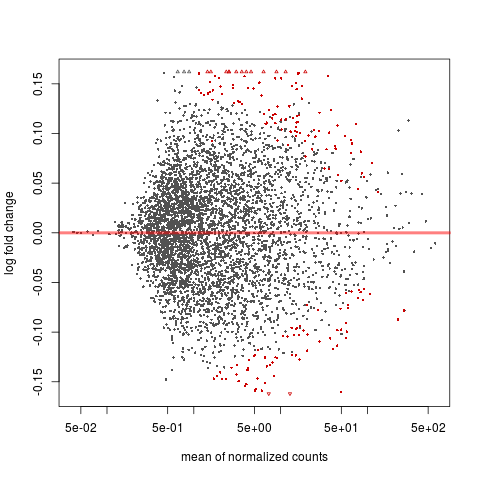

In [48]:
%%R
EnzRes = results(d_dds, name="EnzPC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [53]:
%%R
register(MulticoreParam(20))
phyEnz = subset_samples(physeq.plant, !is.na(EnzPC1) & TimePoint != "T0" & Plant != "Bare")
dds = phyloseq_to_deseq2(phyEnz, ~Rep + TimePoint + EnzPC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept"   "Rep1"        "Rep2"        "Rep3"        "Rep4"       
[6] "TimePointT1" "TimePointT2" "TimePointT3" "EnzPC2"     



out of 4592 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 177, 3.9% 
LFC < 0 (down)   : 116, 2.5% 
outliers [1]     : 0, 0% 
low counts [2]   : 1692, 37% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


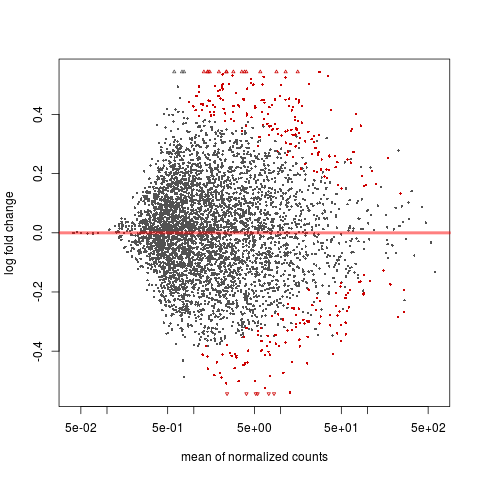

In [58]:
%%R
EnzRes2 = results(d_dds, name="EnzPC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes2) %>% print
plotMA(EnzRes2)

EnzRes2$OTU = rownames(EnzRes2)
df_pc2 = EnzRes2 %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [59]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

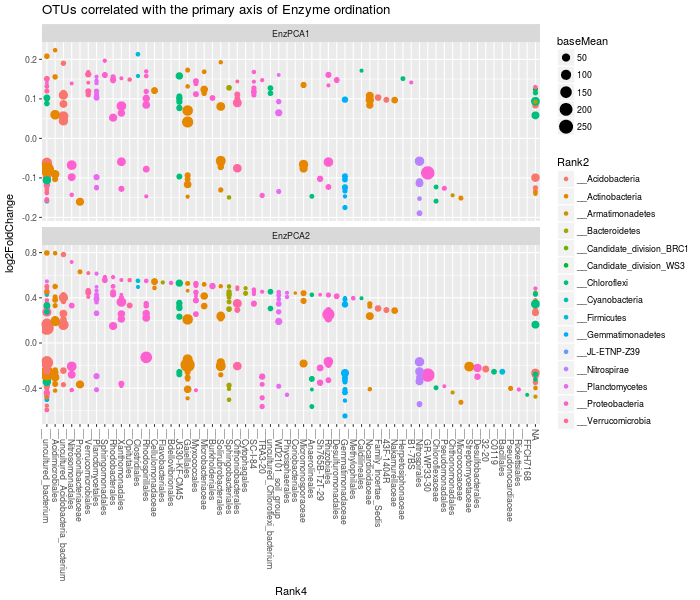

In [62]:
%%R -w 700 -h 600
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2
   

* More likely these are OTUs responding to time point, which cannot be fully corrected for in DESeq

In [64]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_EnzOrd_sig.csv', row.names = FALSE)

# Ordinate enzyme data - timepoints seperately

## T1

In [210]:
%%R
physeq.plant.t1 = subset_samples(physeq.plant, TimePoint == "T1" & !X.sampleID %in%  
                                 c("ERA-T1_3-5c_0","ERA-T1_4-5b_85")) # removing two multivariate outliers, 
                                                                    #run with samples to visualize
physeq.plant.t1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 70 samples ]
sample_data() Sample Data:       [ 70 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.8415 0.6458 0.40380 0.16960
Proportion of Variance 0.8478 0.1043 0.04076 0.00719
Cumulative Proportion  0.8478 0.9520 0.99281 1.00000
                     PC1        PC2         PC3         PC4
BG_activity.g  0.4953908  0.4392308 -0.72795055  0.17819175
CB_activity.g  0.4837800  0.5663562  0.66703969 -0.01598999
LAP_activity.g 0.4993322 -0.5788197  0.14436642  0.62832592
NAG_activity.g 0.5207805 -0.3889534 -0.06560779 -0.75709878


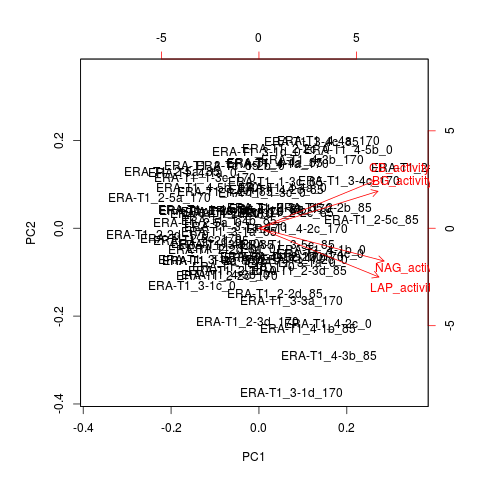

In [211]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant.t1), "data.frame")
rownames(sd) = sd$X.sample


fit = prcomp(~BG_activity.g + CB_activity.g + LAP_activity.g + NAG_activity.g, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(physeq.plant.t1) = TM_Fit

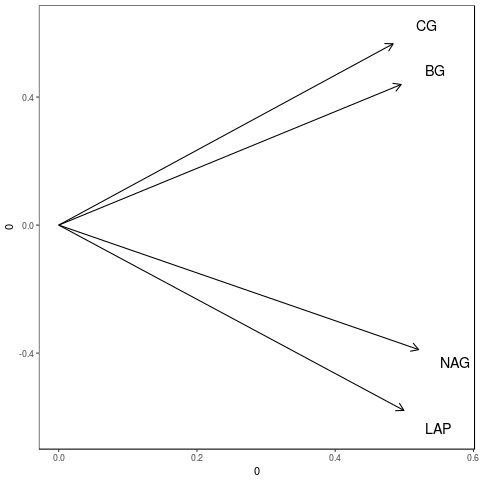

In [161]:
%%R
# Now add the environmental variables as arrows
arrowmat <- vegan::scores(fit, display = "species")

rownames(arrowmat) = c("BG", "CG", "LAP", "NAG")
#rownames(arrowmat) = c("BX", "CB", "LAP", "NAG")

# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = PC1, 
    yend = PC2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.1 * PC1, 
    y = 1.1 * PC2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

pA.1 = ggplot() +
    geom_segment(arrow_map, 
    #size = .5, 
    data = arrowdf, 
    color = "black", 
    arrow = arrowhead
    ) + 
geom_text(label_map,   
    data = arrowdf, 
    show_guide = FALSE, size = 5) + 
    theme_pub()  
    #theme(axis.text = element_blank())
pA.1

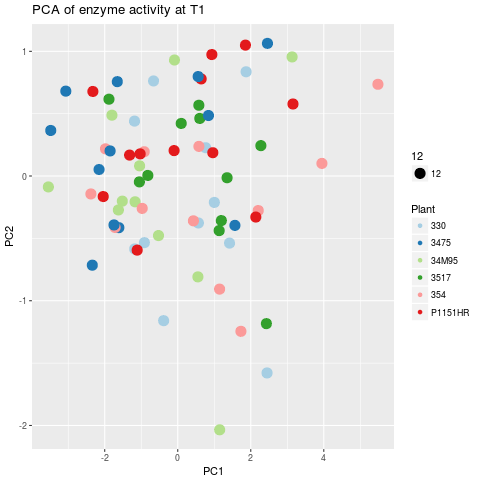

In [212]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity at T1")
p

## Year of release effects at T1

In [216]:
%%R

m1 = lmer(PC1~R_Year.c*Fert + (1|Rep) +(1|Genotype) + (1|Pos) + (1|Pos:Fert) + (1|Rep:Row:Pos),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.c*Fert + (1|Rep) + +(1|Genotype) + (1|Pos) + (1|Pos:Fert) + (1|Rep:Row:Pos),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
              Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
R_Year.c      2.4985 2.49848     1  3.792 1.07687 0.3610
Fert          2.1368 1.06839     2 28.772 0.46048 0.6355
R_Year.c:Fert 1.3478 0.67391     2 40.755 0.29046 0.7495
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
R_Year.c      1.63040 1.63040     1  3.793  4.5585 0.1034
Fert          0.06872 0.03436     2 27.386  0.0961 0.9087
R_Year.c:Fert 0.30824 0.15412     2 40.847  0.4309 0.6528


In [102]:
%%R

m1 = lmer(PC1~poly(R_Year.c,2)*Fert + (1|Rep) +(1|Genotype) + (1|Pos) + (1|Pos:Fert) + (1|Rep:Row:Pos),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~poly(R_Year.c,2)*Fert + (1|Rep) + +(1|Genotype) + (1|Pos) + (1|Pos:Fert) + (1|Rep:Row:Pos),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                       Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
poly(R_Year.c, 2)      1.7969 0.89845     2  2.905 0.41651 0.6934
Fert                   2.4626 1.23130     2  4.927 0.57082 0.5985
poly(R_Year.c, 2):Fert 9.0417 2.26042     4 39.314 1.04791 0.3950
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                        Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
poly(R_Year.c, 2)      1.61362 0.80681     2  2.815 2.24565 0.2612
Fert                   0.24557 0.12279     2  4.699 0.34176 0.7268
poly(R_Year.c, 2):Fert 1.63868 0.40967     4 39.913 1.14026 0.3516


## Treatment effects at T1

In [103]:
%%R
TM_Fit = TM_Fit %>% mutate(R_Year.f = factor(R_Year))
m1 = lmer(PC1~R_Year.f*Fert + (1|Rep) + (1|Pos) + (1|Pos:Fert) + (1|Rep:Row:Pos),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.f*Fert + (1|Rep) + (1|Pos) + (1|Pos:Fert) + (1|Rep:Row:Pos),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
R_Year.f      12.2999 2.45999     5 13.172 1.09986 0.4058
Fert           1.7075 0.85377     2  4.091 0.38172 0.7047
R_Year.f:Fert 17.2148 1.72148    10 29.413 0.76968 0.6561
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
              Sum Sq Mean Sq NumDF   DenDF F.value Pr(>F)
R_Year.f      1.6519 0.33037     5 13.2048 0.91867 0.4987
Fert          0.1883 0.09417     2  3.6588 0.26187 0.7829
R_Year.f:Fert 3.6695 0.36695    10 28.7249 1.02039 0.4511


# plot treatment effects on enzymes at T1

In [55]:
%%R
#Generate lsmeans for Axes1 

Axis1.lsm.df = lsmeans(m1, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

Genotype.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "R_Year.f") 
Genotype.lsm.df

  R_Year.f Axis1.lsmean  Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1     1939    0.2543394 0.7413548     -1.3387580      1.8474368 -0.243364833
2     1953    0.6782504 0.7269839     -0.8969219      2.2534227 -0.226675571
3     1971    0.4400061 0.7415724     -1.1534522      2.0334644  0.004920251
4     1984   -1.0330562 0.7440720     -2.6572902      0.5911778  0.168050381
5     2001   -0.4984003 0.7587417     -2.1429378      1.1461371 -0.099914705
6     2011    0.1054422 0.7247276     -1.4618214      1.6727059  0.320033516
   Axis2.SE Axis2.lower.CL Axis2.upper.CL
1 0.2205475     -0.7262232      0.2394936
2 0.2130306     -0.6994120      0.2460608
3 0.2206320     -0.4781690      0.4880095
4 0.2177238     -0.3325550      0.6686558
5 0.2248357     -0.6083408      0.4085113
6 0.2124625     -0.1480731      0.7881401


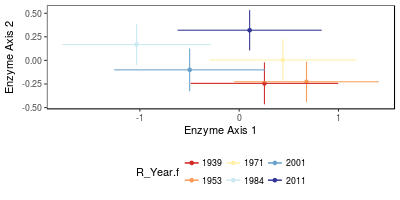

In [58]:
%%R -w 400 -h 200

pG.1 = ggplot(Genotype.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = R_Year.f)) +
    scale_color_manual(values = GenotypeColors_sub6) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = R_Year.f),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = R_Year.f),
                height = .002) +
    theme(legend.position = "bottom")+
    xlab("Enzyme Axis 1")+
    ylab("Enzyme Axis 2")#
pG.1  %>% print
pG.1 = pG.1 + theme(legend.position = "none")

In [59]:
%%R
#Generate lsmeans for Axes1 

Axis1.lsm.df = lsmeans(m1, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

Fert.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "Fert") 
Fert.lsm.df

  Fert Axis1.lsmean  Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1    0    0.1612565 0.5630596      -1.221949       1.544462  0.052732971
2   85    0.1301392 0.5584349      -1.253355       1.513633  0.007647937
3  170   -0.3181050 0.5540315      -1.702745       1.066535 -0.098856388
   Axis2.SE Axis2.lower.CL Axis2.upper.CL
1 0.1721218     -0.3793541      0.4848201
2 0.1701044     -0.4252769      0.4405728
3 0.1679314     -0.5338462      0.3361334


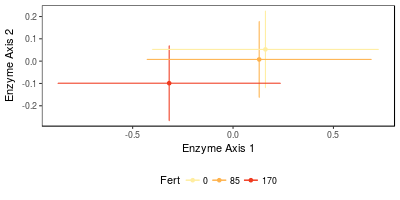

In [61]:
%%R -w 400 -h 200
pF.1 = ggplot(Fert.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = Fert)) +
    scale_color_manual(values = FertColors)+
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Fert),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Fert),
                height = .002) +
    theme(legend.position = "bottom")+
    xlab("Enzyme Axis 1")+
    ylab("Enzyme Axis 2")#
pF.1 %>% print
pF.1 = pF.1 +     theme(legend.position = "none")

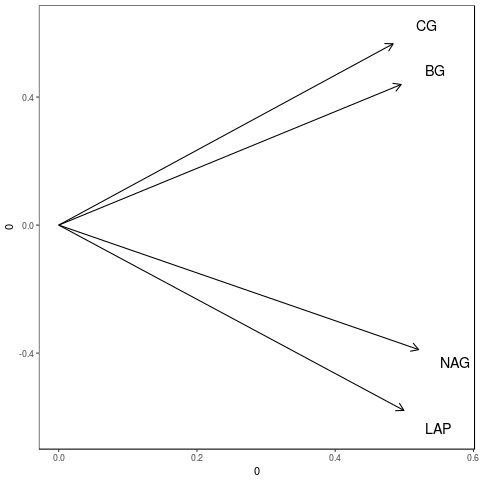

In [158]:
%%R
pA.1 = ggplot() +
    geom_segment(arrow_map, 
    #size = .5, 
    data = arrowdf, 
    color = "black", 
    arrow = arrowhead
    ) + 
geom_text(label_map,   
    data = arrowdf, 
    show_guide = FALSE, size = 5) + 
    theme_pub()  
    #theme(axis.text = element_blank())
pA.1

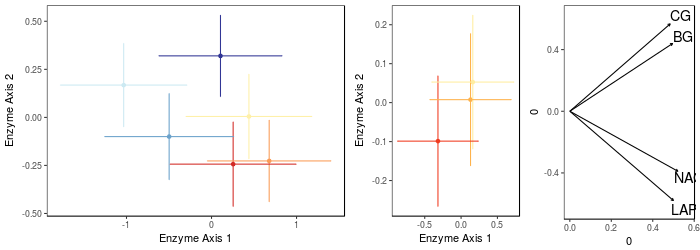

In [160]:
%%R -w 700 -h 250
grid.arrange(pG.1, pF.1, pA.1, ncol = 3, widths = c(2,1,1))

In [63]:
%%R
TM_Fit = TM_Fit %>% 
    mutate(R_Year.c = R_Year - 1935)
m1 = lmer(PC1~R_Year.c *Fert + (1|Rep) + (1|Genotype) + (1|Rep:Row:Pos) + (1|Pos:Fert),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.c * Fert + (1|Rep) + (1|Genotype) + (1|Rep:Row:Pos) + (1|Pos:Fert),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
              Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
R_Year.c      2.9665 2.96649     1  3.921 1.29385 0.3200
Fert          2.0774 1.03869     2 28.875 0.45303 0.6401
R_Year.c:Fert 1.4069 0.70345     2 40.443 0.30681 0.7375
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
R_Year.c      1.40646 1.40646     1  3.844  4.0025 0.1189
Fert          0.05422 0.02711     2 29.179  0.0772 0.9259
R_Year.c:Fert 0.26546 0.13273     2 40.342  0.3777 0.6878


## DESeq of T1 enzymes

In [304]:
%%R
sample_data(physeq.plant.t1)$Rep = as.factor(sample_data(physeq.plant.t1)$Rep)
sample_data(physeq.plant.t1)$Fert = as.factor(sample_data(physeq.plant.t1)$Fert)
sample_data(physeq.plant.t1)$ERA = as.factor(sample_data(physeq.plant.t1)$ERA)
sample_data(physeq.plant.t1)$R_Year.c = sample_data(physeq.plant.t1)$R_Year - 1935

In [305]:
%%R
t.df = tax_table(physeq.plant.t1) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [306]:
%%R
tmp.1 = subset_samples(physeq.plant.t1, !is.na(PC1))
dds = phyloseq_to_deseq2(tmp.1, ~Rep + PC1 + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "PC1"      
[7] "PC2"      



out of 4582 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 12, 0.26% 
LFC < 0 (down)   : 2, 0.044% 
outliers [1]     : 0, 0% 
low counts [2]   : 3197, 70% 
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


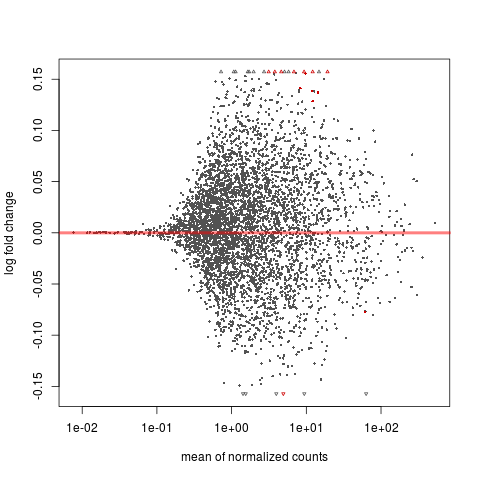

In [307]:
%%R
EnzRes = results(d_dds, name="PC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [308]:
%%R
#Normalized counts per sample:
df_pc1 %>% 
    #group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T1") %>% print



[1] "30051.7181892838 normalized reads at T1"


In [98]:
# %%R

# dds = phyloseq_to_deseq2(tmp.1, ~Rep + PC2)
# d_dds = DESeq(dds, parallel = TRUE)
# resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "PC2"      



out of 4582 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


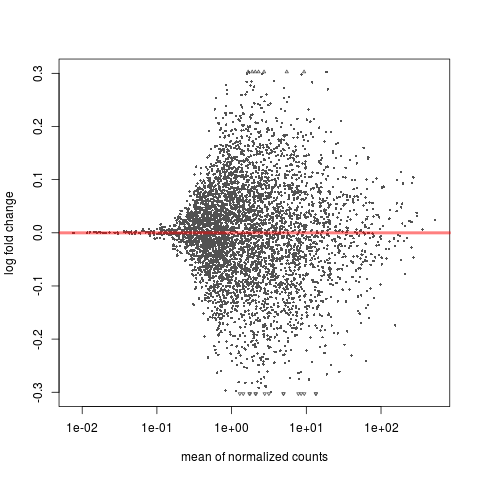

In [144]:
%%R
EnzRes = results(d_dds, name="PC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc2 = EnzRes %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [145]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

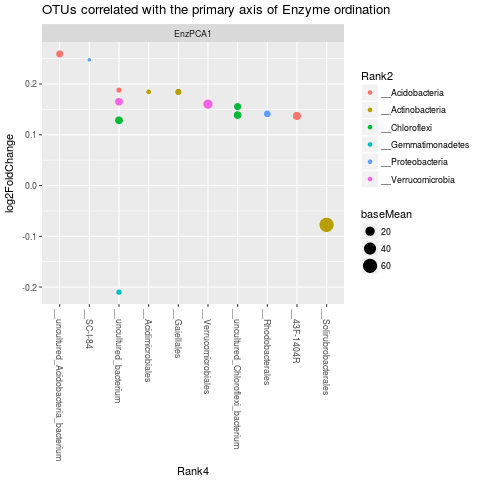

In [146]:
%%R
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2
   

In [147]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t1_sig.csv', row.names = FALSE)

## T2

In [217]:
%%R
physeq.plant.t2 = subset_samples(physeq.Full, TimePoint == "T2" & Genotype != "Bare")
physeq.plant.t2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 64 samples ]
sample_data() Sample Data:       [ 64 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


Importance of components:
                          PC1    PC2    PC3     PC4
Standard deviation     1.6354 0.8607 0.6522 0.39912
Proportion of Variance 0.6686 0.1852 0.1063 0.03982
Cumulative Proportion  0.6686 0.8538 0.9602 1.00000
                      PC1         PC2        PC3        PC4
BG_activity.g  -0.5043251  0.48760405 -0.4854776 -0.5217374
CB_activity.g  -0.5737849  0.04915661 -0.2050679  0.7913922
LAP_activity.g -0.4008918 -0.86036349 -0.1507576 -0.2762835
NAG_activity.g -0.5056806  0.14000213  0.8363796 -0.1586057


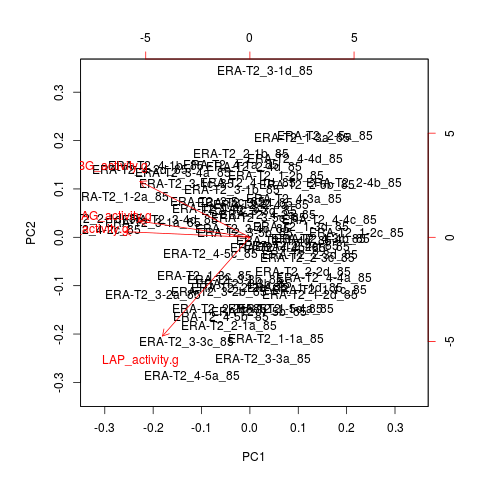

In [218]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant.t2), "data.frame")
rownames(sd) = sd$X.sample


fit = prcomp(~BG_activity.g  + CB_activity.g + LAP_activity.g + NAG_activity.g, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(physeq.plant.t2) = TM_Fit


In [145]:
%%R


# Now add the environmental variables as arrows
arrowmat <- vegan::scores(fit, display = "species")

rownames(arrowmat) = c("BG", "CG", "LAP", "NAG")
#rownames(arrowmat) = c("BX", "CB", "LAP", "NAG")

# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = PC1, 
    yend = PC2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.1 * PC1, 
    y = 1.1 * PC2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

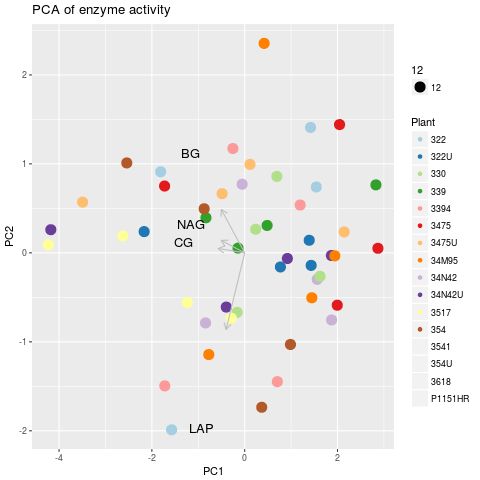

In [125]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity")



p

## Treatment effects at T2

In [219]:
%%R
sub  = TM_Fit %>% filter(SeedTreatment != "Untreated") %>%
mutate(R_Year.f = factor(R_Year))
m1 = lmer(PC1~R_Year.f  + (1|Rep),  data = sub, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.f  + (1|Rep),  data = sub, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
         Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
R_Year.f 36.876  3.3523    11    33  2.2795 0.03334 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
         Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.f  3.486 0.31691    11    33 0.28752  0.984


### Plot treatments at T2

In [113]:
%%R
#Generate lsmeans for Axes1 

Axis1.lsm.df = lsmeans(m1, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

Genotype.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "R_Year.f") 
Genotype.lsm.df

   R_Year.f Axis1.lsmean  Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1      1936  -0.10529878 0.7481175     -1.6938107      1.4832131   0.26822699
2      1939   0.59785381 0.7481175     -0.9906581      2.1863657   0.04774559
3      1942   0.58307682 0.7481175     -1.0054351      2.1715887   0.37985136
4      1953  -0.51524792 0.7481175     -2.1037598      1.0732640  -0.31484662
5      1961   0.33460341 0.7481175     -1.2539085      1.9231153  -0.20548694
6      1971  -2.09555529 0.7481175     -3.6840672     -0.5070434  -0.25318442
7      1975  -1.04868772 0.7481175     -2.6371996      0.5398242  -0.26879142
8      1984   1.29600207 0.7481175     -0.2925099      2.8845140   0.41371343
9      1991  -0.01915973 0.7481175     -1.6076717      1.5693522  -0.30806755
10     2001   0.75855539 0.7481175     -0.8299565      2.3470673   0.16815747
11     2003   0.63427872 0.7481175     -0.9542332      2.2227906  -0.26710759
12     2011   0.02101181 0.7481175     -1.5675001      1.6095237

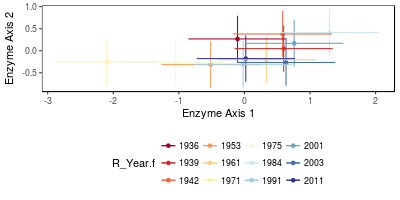

In [114]:
%%R -w 400 -h 200
# Flip axis 1 for consistency with T1
pG.2 = ggplot(Genotype.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = R_Year.f)) +
    scale_color_manual(values = GenotypeColors)+
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = R_Year.f),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, 
                       color = R_Year.f),
                height = .002) +
    theme(legend.position = "bottom")+
    xlab("Enzyme Axis 1")+
    ylab("Enzyme Axis 2") #
pG.2 %>% print
pG.2 = pG.2 + theme(legend.position = "none")

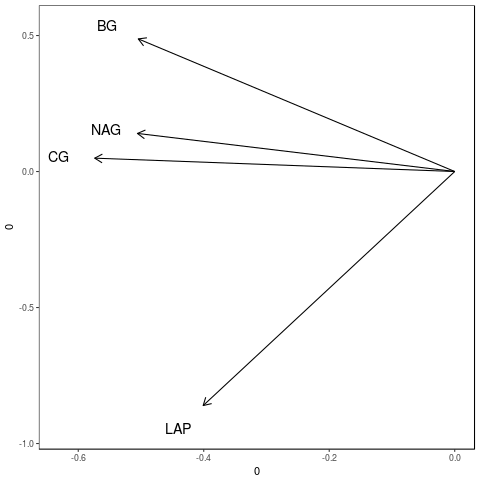

In [152]:
%%R
pA = ggplot() +
    geom_segment(arrow_map, 
    #size = .5, 
    data = arrowdf, 
    color = "black", 
    arrow = arrowhead
    ) + 
geom_text(label_map,   
    data = arrowdf, 
    show_guide = FALSE, size = 5) + 
    theme_pub()  
    #theme(axis.text = element_blank())
pA

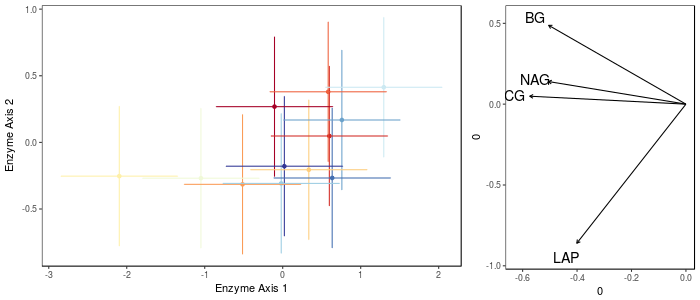

In [153]:
%%R -w 700 -h 300
grid.arrange(pG.2, pA, ncol = 2, widths = c(4,2))

In [ ]:
* Test year of release

In [220]:
%%R
#TM_Fit = TM_Fit %>% 
 #   mutate(R_Year.c = R_Year - 1935)
sub  = TM_Fit %>% filter(SeedTreatment != "Untreated")
m1 = lmer(PC1~R_Year.c + (1|Rep) + (1|Genotype),  data = sub, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.c  + (1|Rep) + (1|Genotype),  data = sub, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
          Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.c 0.18089 0.18089     1    10   0.123 0.7331
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
          Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.c 0.35777 0.35777     1    10 0.38445 0.5491


In [221]:
%%R
#TM_Fit = TM_Fit %>% 
 #   mutate(R_Year.c = R_Year - 1935)
sub  = TM_Fit %>% filter(SeedTreatment != "Untreated")
m1 = lmer(PC1~poly(R_Year.c,2) + (1|Rep) + (1|Genotype),  data = sub, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~poly(R_Year.c,2)  + (1|Rep) + (1|Genotype),  data = sub, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
poly(R_Year.c, 2) 2.5166  1.2583     2     9 0.85562 0.4569
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                   Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
poly(R_Year.c, 2) 0.67861 0.33931     2     9 0.35938 0.7077


* Genotype effect, but no relationship to year of releaese.
* Also checked polynomial with year of release, but no  dice


### check seed treatment

In [346]:
%%R
TM_Fit$Plant %>% levels

 [1] "322"     "322U"    "330"     "339"     "3394"    "3475"    "3475U"  
 [8] "34M95"   "34N42"   "34N42U"  "3517"    "354"     "3541"    "354U"   
[15] "3618"    "P1151HR"


In [348]:
%%R

sub  = TM_Fit %>% filter(Genotype %in%  c("322", "3475", "34N42", "354"))
mT1 = lmer(PC1~Genotype*SeedTreatment  + (1|Rep),  data = sub, na.action = na.exclude)
  print("Enz1")
  anova(mT1, ddf = "Kenward-Roger") %>% print

mT2 = lmer(PC2~Genotype*SeedTreatment  + (1|Rep),  data = sub, na.action = na.exclude)
  print("Enz2")
  anova(mT2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                       Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
Genotype               1.6992 0.56641     3    21 0.16840 0.9165
SeedTreatment          1.5333 1.53329     1    21 0.45585 0.5069
Genotype:SeedTreatment 7.8971 2.63237     3    21 0.78261 0.5169
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                        Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
Genotype               2.58792 0.86264     3    21 1.16880 0.3452
SeedTreatment          0.08767 0.08767     1    21 0.11879 0.7338
Genotype:SeedTreatment 0.35612 0.11871     3    21 0.16084 0.9215


## DESeq of T2 enzymes

In [354]:
%%R
sample_data(physeq.plant.t2)$Rep = as.factor(sample_data(physeq.plant.t2)$Rep)
sample_data(physeq.plant.t2)$Fert = as.factor(sample_data(physeq.plant.t2)$Fert)
sample_data(physeq.plant.t2)$ERA = as.factor(sample_data(physeq.plant.t2)$ERA)
sample_data(physeq.plant.t2)$R_Year.c = sample_data(physeq.plant.t2)$R_Year - 1935

In [355]:
%%R
t.df = tax_table(physeq.plant.t2) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [357]:
%%R
phy.tmp = physeq.plant.t2 %>% subset_samples(SeedTreatment != "Untreated")
dds = phyloseq_to_deseq2(phy.tmp, ~Rep + PC1 + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
phy.tmp = NULL

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "PC1"      
[7] "PC2"      



out of 4589 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 1, 0.022% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


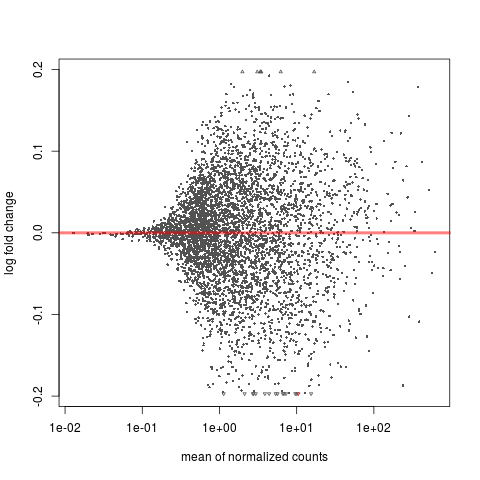

In [358]:
%%R
EnzRes = results(d_dds, name="PC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [359]:
%%R
#Normalized counts per sample:
df_pc1 %>% 
    #group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T2") %>% print


[1] "31964.6608886275 normalized reads at T2"


In [130]:
#%%R

# dds = phyloseq_to_deseq2(physeq.plant.t2, ~PC2)
# d_dds = DESeq(dds, parallel = TRUE)
# resultsNames(d_dds) %>% print

[1] "Intercept" "PC2"      



out of 4589 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 1, 0.022% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


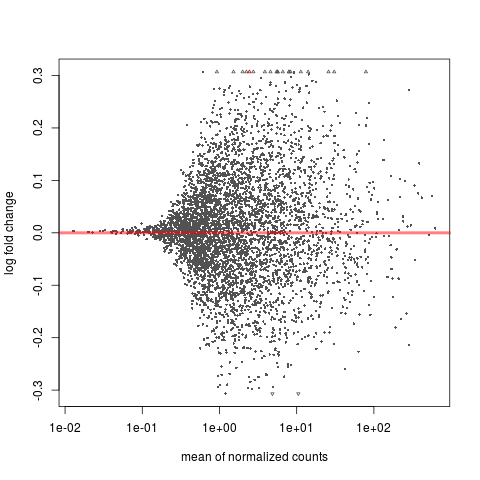

In [360]:
%%R
EnzRes = results(d_dds, name="PC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc2 = EnzRes %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [361]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

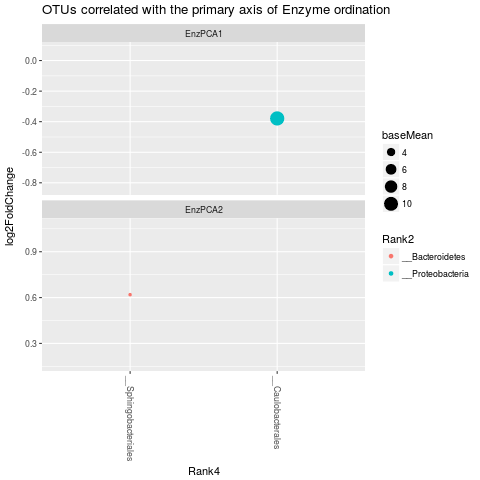

In [362]:
%%R
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2
   

In [363]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t2_sig.csv', row.names = FALSE)

## Deseq of Enzyme ordination and MCC at T3

In [222]:
%%R
physeq.plant.t3 = subset_samples(physeq.plant, TimePoint == "T3")
physeq.plant.t3

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.6225 1.0105 0.47848 0.34303
Proportion of Variance 0.6581 0.2553 0.05724 0.02942
Cumulative Proportion  0.6581 0.9133 0.97058 1.00000
                      PC1         PC2         PC3        PC4
BG_activity.g  -0.5730204  0.06398277 -0.68969419  0.4380362
CB_activity.g  -0.5918057 -0.04136671 -0.02321411 -0.8046838
LAP_activity.g -0.2266984  0.90510393  0.34238040  0.1103194
NAG_activity.g -0.5196359 -0.41830836  0.63761955  0.3852765


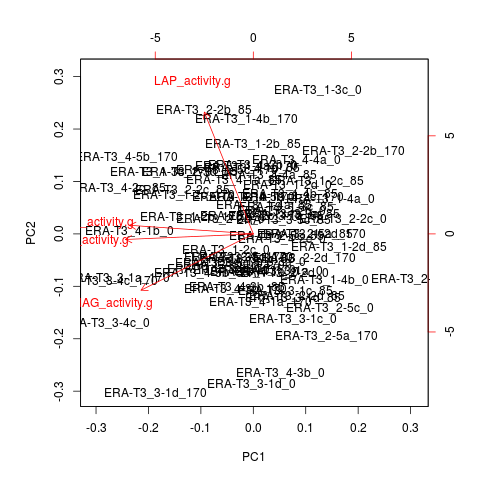

In [223]:
%%R
# # PCA of enzymes
sd = as(sample_data(physeq.plant.t3), "data.frame")
rownames(sd) = sd$X.sample


fit = prcomp(~BG_activity.g + CB_activity.g + LAP_activity.g + NAG_activity.g, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(physeq.plant.t3) = TM_Fit


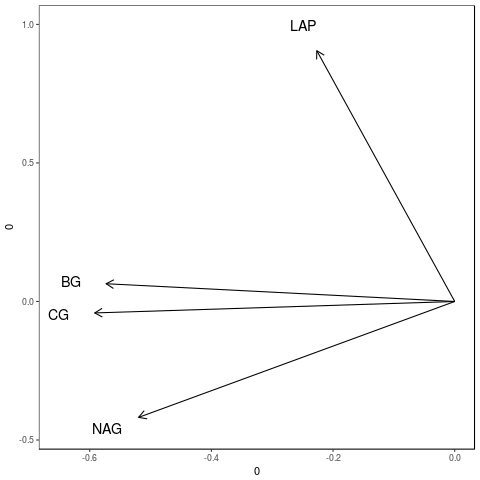

In [164]:
%%R
# Now add the environmental variables as arrows
arrowmat <- vegan::scores(fit, display = "species")

rownames(arrowmat) = c("BG", "CG", "LAP", "NAG")
#rownames(arrowmat) = c("BX", "CB", "LAP", "NAG")

# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = PC1, 
    yend = PC2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.1 * PC1, 
    y = 1.1 * PC2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

pA.3 = ggplot() +
    geom_segment(arrow_map, 
    #size = .5, 
    data = arrowdf, 
    color = "black", 
    arrow = arrowhead
    ) + 
geom_text(label_map,   
    data = arrowdf, 
    show_guide = FALSE, size = 5) + 
    theme_pub()  
    #theme(axis.text = element_blank())
pA.3

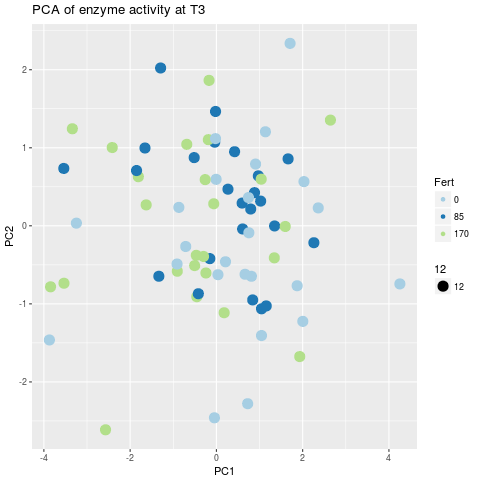

In [106]:
%%R
p = ggplot(TM_Fit, aes(PC1, PC2, color = Fert, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of enzyme activity at T3") 
p

## Treatment effects at T3

In [166]:
%%R
TM_Fit = mutate(TM_Fit, R_Year.f = factor(R_Year))
m1 = lmer(PC1~R_Year.f*Fert + (1|Rep) + (1|Pos) + (1|Rep:Row:Pos) + (1|Pos:Fert),  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.f*Fert + (1|Rep) + (1|Pos) + (1|Rep:Row:Pos) + (1|Pos:Fert),  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF   DenDF F.value Pr(>F)
R_Year.f       6.8442  1.3688     5 12.8672 0.58906 0.7087
Fert          14.2664  7.1332     2  3.6463 3.06968 0.1653
R_Year.f:Fert  8.8241  0.8824    10 31.5180 0.37973 0.9463
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
              Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
R_Year.f      2.7253 0.54506     5 13.056 1.22474 0.3518
Fert          1.5792 0.78959     2  4.529 1.77418 0.2698
R_Year.f:Fert 4.1215 0.41215    10 32.471 0.92609 0.5224


In [167]:
%%R
#Generate lsmeans for Axes1 

Axis1.lsm.df = lsmeans(m1, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

Genotype.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "R_Year.f") 
Genotype.lsm.df

  R_Year.f Axis1.lsmean  Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1     1939  -0.46803390 0.5620614     -1.6709565      0.7348887   -0.1250817
2     1953   0.10362019 0.5620648     -1.0994283      1.3066687    0.2451854
3     1971  -0.14047967 0.5620608     -1.3433799      1.0624206    0.6196165
4     1984   0.78234747 0.5627121     -0.4366231      2.0013181   -0.2069888
5     2001  -0.02330863 0.5627121     -1.2422792      1.1956620   -0.4435681
6     2011  -0.24359371 0.5620590     -1.4464293      0.9592418   -0.1300770
   Axis2.SE Axis2.lower.CL Axis2.upper.CL
1 0.4224879     -1.0606237      0.8104604
2 0.4226686     -0.6905831      1.1809539
3 0.4224564     -0.3158642      1.5550971
4 0.4262563     -1.1479015      0.7339240
5 0.4262563     -1.3844808      0.4973447
6 0.4223917     -1.0655234      0.8053694


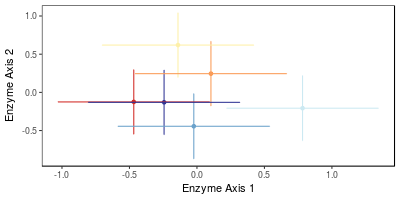

In [169]:
%%R -w 400 -h 200
#reverse both axes to match T1
pG.3 = ggplot(Genotype.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = R_Year.f)) +
    geom_point()+
    theme_pub()+
    scale_color_manual(values = GenotypeColors_sub6)+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, 
                      color = R_Year.f),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, 
                       color = R_Year.f),
                height = .002) +
    theme(legend.position = "none")+
    xlab("Enzyme Axis 1")+
    ylab("Enzyme Axis 2")#
pG.3

In [170]:
%%R
#Generate lsmeans for Axes1 

Axis1.lsm.df = lsmeans(m1, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

Fert.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "Fert") 
Fert.lsm.df

  Fert Axis1.lsmean  Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1    0    0.4841017 0.4036072     -0.5094374      1.4776409  -0.23878029
2   85    0.1296070 0.4036072     -0.8639322      1.1231461   0.28970361
3  170   -0.6084328 0.4036072     -1.6019720      0.3851063  -0.07138009
   Axis2.SE Axis2.lower.CL Axis2.upper.CL
1 0.3475786     -1.1149794      0.6374188
2 0.3475786     -0.5864955      1.1659027
3 0.3475786     -0.9475792      0.8048190


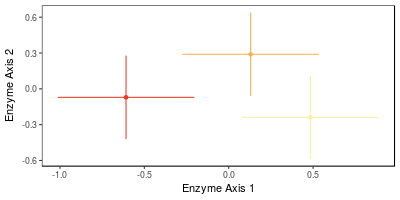

In [171]:
%%R -w 400 -h 200
pF.3 = ggplot(Fert.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = Fert)) +
    scale_color_manual(values = FertColors) + 
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Fert),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Fert),
                height = .002) +
    theme(legend.position = "none")+
    xlab("Enzyme Axis 1")+
    ylab("Enzyme Axis 2")#
pF.3

In [224]:
%%R
TM_Fit = TM_Fit %>% 
    mutate(R_Year.c = R_Year - 1935)
m1 = lmer(PC1~R_Year.c*Fert + (1|Rep) + (1|Genotype) + (1|Pos) + (1|Pos:Fert) + (1|Rep:Row:Pos) ,  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~R_Year.c*Fert + (1|Rep) + (1|Genotype) + (1|Pos) + (1|Pos:Fert) + (1|Rep:Row:Pos) ,  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
R_Year.c      0.31755 0.31755     1  3.828 0.15123 0.7180
Fert          2.04782 1.02391     2 31.539 0.48763 0.6186
R_Year.c:Fert 0.49497 0.24749     2 42.013 0.11786 0.8891
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
R_Year.c      0.38419 0.38419     1  3.896 0.80991 0.4203
Fert          1.52447 0.76223     2 25.834 1.60689 0.2199
R_Year.c:Fert 0.23704 0.11852     2 40.993 0.24986 0.7801


In [225]:
%%R
TM_Fit = TM_Fit %>% 
    mutate(R_Year.c = R_Year - 1935)
m1 = lmer(PC1~poly(R_Year.c,2)*Fert + (1|Rep) + (1|Genotype) + (1|Pos) + (1|Pos:Fert) + (1|Rep:Row:Pos) ,  data = TM_Fit, na.action = na.exclude)
  print("Enz1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2 = lmer(PC2~poly(R_Year.c,2)*Fert + (1|Rep) + (1|Genotype) + (1|Pos) + (1|Pos:Fert) + (1|Rep:Row:Pos) ,  data = TM_Fit, na.action = na.exclude)
  print("Enz2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Enz1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                        Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
poly(R_Year.c, 2)       3.6550  1.8275     2  2.934  0.8569 0.5092
Fert                   14.3103  7.1551     2  4.870  3.3548 0.1214
poly(R_Year.c, 2):Fert  3.1064  0.7766     4 41.130  0.3641 0.8327
[1] "Enz2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                        Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
poly(R_Year.c, 2)      0.78861 0.39430     2  2.943 0.80815 0.5251
Fert                   2.00112 1.00056     2  5.318 2.05071 0.2187
poly(R_Year.c, 2):Fert 0.49231 0.12308     4 40.049 0.25226 0.9066


## DESeq of T3 enzymes

In [321]:
%%R
sample_data(physeq.plant.t3)$Rep = as.factor(sample_data(physeq.plant.t3)$Rep)
sample_data(physeq.plant.t3)$Fert = as.factor(sample_data(physeq.plant.t3)$Fert)
sample_data(physeq.plant.t3)$ERA = as.factor(sample_data(physeq.plant.t3)$ERA)
sample_data(physeq.plant.t3)$R_Year.c = sample_data(physeq.plant.t3)$R_Year - 1935

In [322]:
%%R
t.df = tax_table(physeq.plant.t3) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [323]:
%%R

dds = phyloseq_to_deseq2(physeq.plant.t3, ~Rep + PC1 + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

[1] "Intercept" "Rep1"      "Rep2"      "Rep3"      "Rep4"      "PC1"      
[7] "PC2"      



out of 4590 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 9, 0.2% 
LFC < 0 (down)   : 9, 0.2% 
outliers [1]     : 0, 0% 
low counts [2]   : 4004, 87% 
(mean count < 10)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


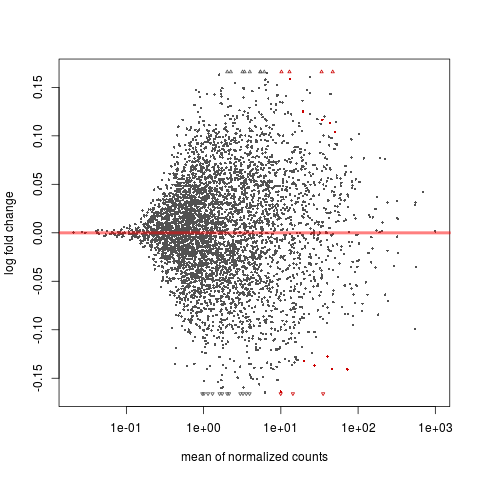

In [324]:
%%R
EnzRes = results(d_dds, name="PC1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc1 = EnzRes %>% as.data.frame()
df_pc1 = left_join(df_pc1, t.df, by = "OTU")

In [325]:
%%R
#Normalized counts per sample:
df_pc1 %>% 
    #group_by(Plant) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at T3") %>% print


[1] "33535.0243078956 normalized reads at T3"



out of 4590 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


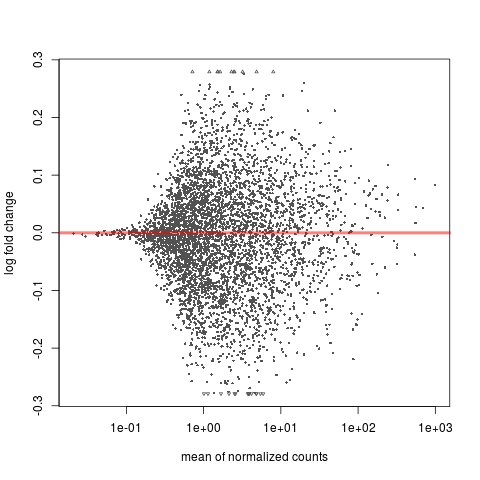

In [173]:
%%R
EnzRes = results(d_dds, name="PC2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(EnzRes) %>% print
plotMA(EnzRes)

EnzRes$OTU = rownames(EnzRes)
df_pc2 = EnzRes %>% as.data.frame()
df_pc2 = left_join(df_pc2, t.df, by = "OTU")

In [174]:
%%R
df_pc1$test = "EnzPCA1"
df_pc2$test = "EnzPCA2"
df_enz = bind_rows(df_pc1, df_pc2)

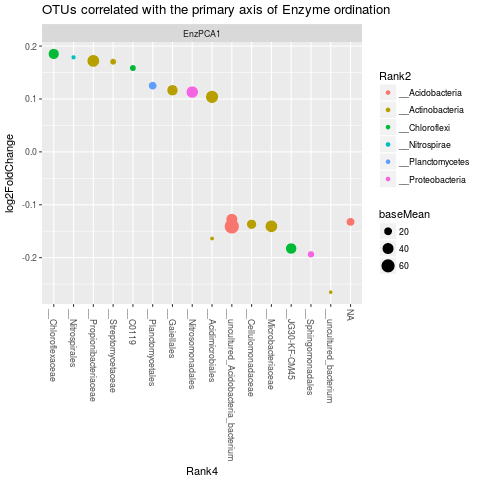

In [175]:
%%R
sigtab = df_enz %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
 # theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with the primary axis of Enzyme ordination")  +
   theme(legend.position="right") +
    facet_wrap(~test, ncol = 1, scales = 'free_y')
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
 
    p2

In [176]:
%%R
write.csv(sigtab, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t3_sig.csv', row.names = FALSE)

## Arrange figure
* Note that axis 1 is flipped in T2 and axis 1 and 2 are flipped in T3 so that loadings all point in the same direction

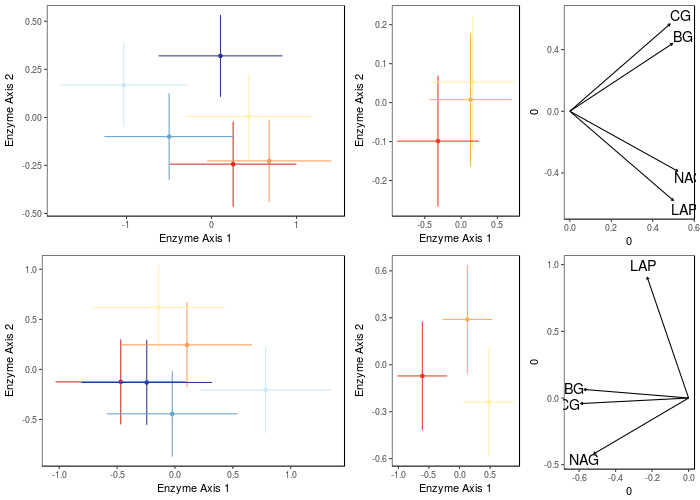

In [195]:
%%R -w 700 -h 500
grid.arrange(pG.1, pF.1, pA.1, pG.3,pF.3, pA.3, ncol = 3, widths = c(2,1,1))
## Use code below for figure that includes R2
#LM = rbind(c(1,1,2), c(3,3,NA), c(4,4,5))
#grid.arrange(pG.1, pF.1, pG.2, pG.3,pF.3, ncol = 2, layout_matrix = LM , heights = c(1.5,2, 1.5))

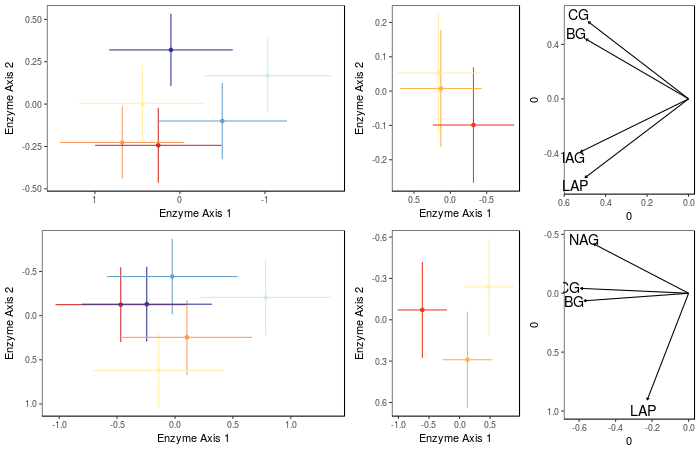

In [196]:
%%R -w 700 -h 450
#flip axes for consistency with T2 figure:
#T1 needs x axis reversed
pG.1a = pG.1 + scale_x_reverse()
pF.1a = pF.1 + scale_x_reverse()
pA.1a = pA.1 + scale_x_reverse()

#T3 needs y axis reversed
pG.3a = pG.3 + scale_y_reverse()
pF.3a = pF.3 + scale_y_reverse()
pA.3a = pA.3 + scale_y_reverse()

GridT1_3 = grid.arrange(pG.1a, pF.1a, pA.1a, pG.3a,pF.3a, pA.3a, ncol = 3, widths = c(2,1,1))

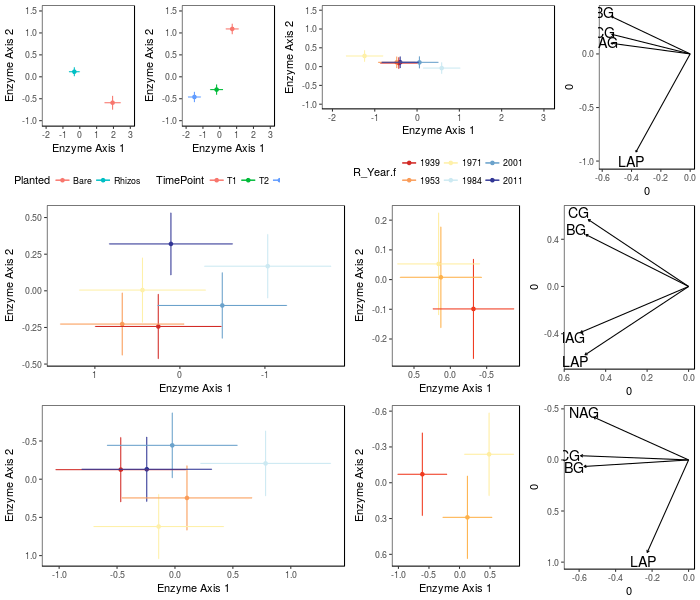

In [199]:
%%R -w 700 -h 600
grid.arrange(GCore, GridT1_3, ncol = 1, heights = c(1,2))